The goal of this notebook is to determine which cytokines and chemokines are found at high levels in pyroptotic inducing agents.
Doing this will allow us to determine ground truth of pyroptosis occurance.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import scipy.stats as stats

# anova test on each group
# import the package hdbscan
import hdbscan
from scipy.stats import f_oneway

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# umap analysis of treatment groups
import warnings

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)
import umap

In [2]:
# set path
df_path = pathlib.Path("../../Data/filtered/nELISA_plate_430420_no_inhibitors.csv")
# read in the data
df = pd.read_csv(df_path)

In [3]:
# create a list of all the groups in the column 'Inducer1_and_dose'
lst = df["Inducer1_and_dose"].unique().tolist()
# remove item from the list if it contains 'topotecan'
lst = [i for i in lst if "Topotecan" not in i]

In [4]:
# create dataframes for each group in lst
# DMSO_0.10%
df_0 = df[df["Inducer1_and_dose"] == lst[0]]
# Flagellin_1 µg/ml
df_1 = df[df["Inducer1_and_dose"] == lst[1]]
# LPS_0.01 µg/ml
df_2 = df[df["Inducer1_and_dose"] == lst[2]]
# LPS_0.1 µg/ml
df_3 = df[df["Inducer1_and_dose"] == lst[3]]
# Flagellin_0.1 µg/ml
df_4 = df[df["Inducer1_and_dose"] == lst[4]]
# Disulfiram_0.1 µM
df_5 = df[df["Inducer1_and_dose"] == lst[5]]
# LPS_1 µg/ml
df_6 = df[df["Inducer1_and_dose"] == lst[6]]
# Disulfiram_1 µM
df_7 = df[df["Inducer1_and_dose"] == lst[7]]
# Thapsigargin_1 µM
df_8 = df[df["Inducer1_and_dose"] == lst[8]]
# LPS_10 µg/ml
df_9 = df[df["Inducer1_and_dose"] == lst[9]]
# Thapsigargin_10 µM
df_10 = df[df["Inducer1_and_dose"] == lst[10]]
# H2O2_100 nM
df_11 = df[df["Inducer1_and_dose"] == lst[11]]
# H2O2_100 µM
df_12 = df[df["Inducer1_and_dose"] == lst[12]]
# LPS_100 µg/ml
df_13 = df[df["Inducer1_and_dose"] == lst[13]]
#   Disulfiram_2.5 µM
df_14 = df[df["Inducer1_and_dose"] == lst[14]]

# create a list of all the dataframes
lst_df = [
    df_0,
    df_1,
    df_2,
    df_3,
    df_4,
    df_5,
    df_6,
    df_7,
    df_8,
    df_9,
    df_10,
    df_11,
    df_12,
    df_13,
    df_14,
]

# filter df to only include items from lst in column 'Inducer1_and_dose'
df = df[df["Inducer1_and_dose"].isin(lst)]
# subset df to onoly include columns that contain '[NSU]'
df_nsu = df.filter(regex="NSU", axis=1)

## Anova and Post-Hoc Analysis
Anova of all treatments and post-hoc analysis of all treatments for each cytokine and chemokine. 
This will determine the cytokines and chemokines that are found at high levels in pyroptotic inducing agents.

In [5]:
# define blank df
final_df_tukey = pd.DataFrame(
    {
        "group1": [""],
        "group2": [""],
        "meandiff": [""],
        "lower": [""],
        "upper": [""],
        "reject": [""],
        "p-adj": [""],
        "cytokine": [""],
    }
)

In [6]:
# loop through each column and do an anova test
num = 0
for col in df_nsu.columns:
    one_way_anova = f_oneway(
        df_0[col],
        df_1[col],
        df_2[col],
        df_3[col],
        df_4[col],
        df_5[col],
        df_6[col],
        df_7[col],
        df_8[col],
        df_9[col],
        df_10[col],
        df_11[col],
        df_12[col],
        df_13[col],
        df_14[col],
    )
    if one_way_anova.pvalue < 0.01:
        num += 1
        tukey = pairwise_tukeyhsd(
            endog=df[col], groups=df["Inducer1_and_dose"], alpha=0.01
        )
        # send the results to a dataframe
        tukey_results = pd.DataFrame(
            data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]
        )
        tukey_results["cytokine"] = f"{col}"
        # concat the results to the blank df
        final_df_tukey = pd.concat([final_df_tukey, tukey_results], axis=0)
    else:
        pass
print(
    f"Out of the {len(df_nsu.columns)} cytokines tested, {num} were significantly different between groups (p < 0.01)"
)

Out of the 187 cytokines tested, 62 were significantly different between groups (p < 0.01)


Clean up the data and filter out tests that are not significant.

In [7]:
# drop the first row of the df
final_df_tukey = final_df_tukey.drop([0], axis=0)
# reset the index
final_df_tukey = final_df_tukey.reset_index(drop=True)

# drop p-adj values that are above 0.01
final_df_tukey = final_df_tukey[final_df_tukey["p-adj"] < 0.01]

# remove the rows that contain 'DMSO' in the 'group1' column
final_df_tukey = final_df_tukey[~final_df_tukey["group1"].str.contains("DMSO")]
# remove the rows that contain 'DMSO' in the 'group2' column
final_df_tukey = final_df_tukey[~final_df_tukey["group2"].str.contains("DMSO")]
# sort the df by p-adj values and group1 and group2 columns
final_df_tukey = final_df_tukey.sort_values(by=["p-adj"], ascending=[True])

In [8]:
# Treatment order list
treatment_order_lst = [
    "DMSO_0.10%",
    "Disulfiram_0.1 µM",
    "Disulfiram_1 µM",
    "Disulfiram_2.5 µM",
    "Flagellin_0.1 µg/ml",
    "Flagellin_1 µg/ml",
    "LPS_0.01 µg/ml",
    "LPS_0.1 µg/ml",
    "LPS_1 µg/ml",
    "LPS_10 µg/ml",
    "LPS_100 µg/ml",
    "Thapsigargin_1 µM",
    "Thapsigargin_10 µM",
    "H2O2_100 nM",
    "H2O2_100 µM",
]

In [9]:
# manually remove some cytokines that are not of interest based on the results of the tukey test
# lst of cytokines to remove
cytokine_remove_lst = [
    "Amphiregulin [NSU]",
    "BMP-2 [NSU]",
    "CCL2 [NSU]",
    "CCL3 [NSU]",
    "CCL4 [NSU]",
    "CCL7 [NSU]",
    "CCL8 [NSU]",
    "CCL16 [NSU]",
    "CCL22 [NSU]",
    "CNTF [NSU]",
    "CXCL3 [NSU]",
    "CXCL5 [NSU]",
    "CXCL7 [NSU]",
    "CXCL9 [NSU]",
    "CXCL10 [NSU]",
    "FAS-L [NSU]",
    "FGF-19 [NSU]",
    "Growth Hormone (Somatotropin) [NSU]",
    "HGF [NSU]",
    "IL-1 RA_RN [NSU]",
    "IL-6 R alpha [NSU]",
    "IL-8 [NSU]",
    "IL-17D [NSU]",
    "IL-24 [NSU]",
    "IL-28A [NSU]",
    "LOX1 (OLR1) [NSU]",
    "Mesothelin [NSU]",
    "NRG1 beta 1 [NSU]",
    "Resistin [NSU]",
    "SAA [NSU]",
    "TIMP-1 [NSU]",
    "VEGF-D [NSU]",
    "VEGFR-1 [NSU]",
    "XCL1 (Lymphotactin) [NSU]",
]

# remove cytokines from the final_df_tukey df
final_df_tukey = final_df_tukey[~final_df_tukey["cytokine"].isin(cytokine_remove_lst)]
final_df_tukey = final_df_tukey.reset_index(drop=True)
final_df_tukey

,group1,group2,meandiff,lower,upper,reject,p-adj,cytokine
0,Disulfiram_0.1 µM,Flagellin_0.1 µg/ml,0.3927,0.2307,0.5546,True,0.0,Activin A [NSU]
1,LPS_100 µg/ml,Thapsigargin_10 µM,-0.9218,-0.9638,-0.8798,True,0.0,IL-1 beta [NSU]
2,LPS_100 µg/ml,Thapsigargin_1 µM,-0.9193,-0.9613,-0.8773,True,0.0,IL-1 beta [NSU]
3,LPS_10 µg/ml,Thapsigargin_10 µM,-0.8667,-0.9087,-0.8247,True,0.0,IL-1 beta [NSU]
4,LPS_10 µg/ml,Thapsigargin_1 µM,-0.8642,-0.9062,-0.8222,True,0.0,IL-1 beta [NSU]
...,...,...,...,...,...,...,...,...
1387,H2O2_100 µM,LPS_0.1 µg/ml,0.3349,0.0016,0.6682,True,0.0094,CCL19 [NSU]
1388,Flagellin_0.1 µg/ml,H2O2_100 µM,-0.2887,-0.5762,-0.0013,True,0.0095,MMP-9 [NSU]
1389,Disulfiram_1 µM,LPS_0.01 µg/ml,0.065,0.0002,0.1299,True,0.0096,IL-16 [NSU]
1390,LPS_0.01 µg/ml,Thapsigargin_10 µM,-0.3339,-0.6671,-0.0006,True,0.0098,CCL19 [NSU]


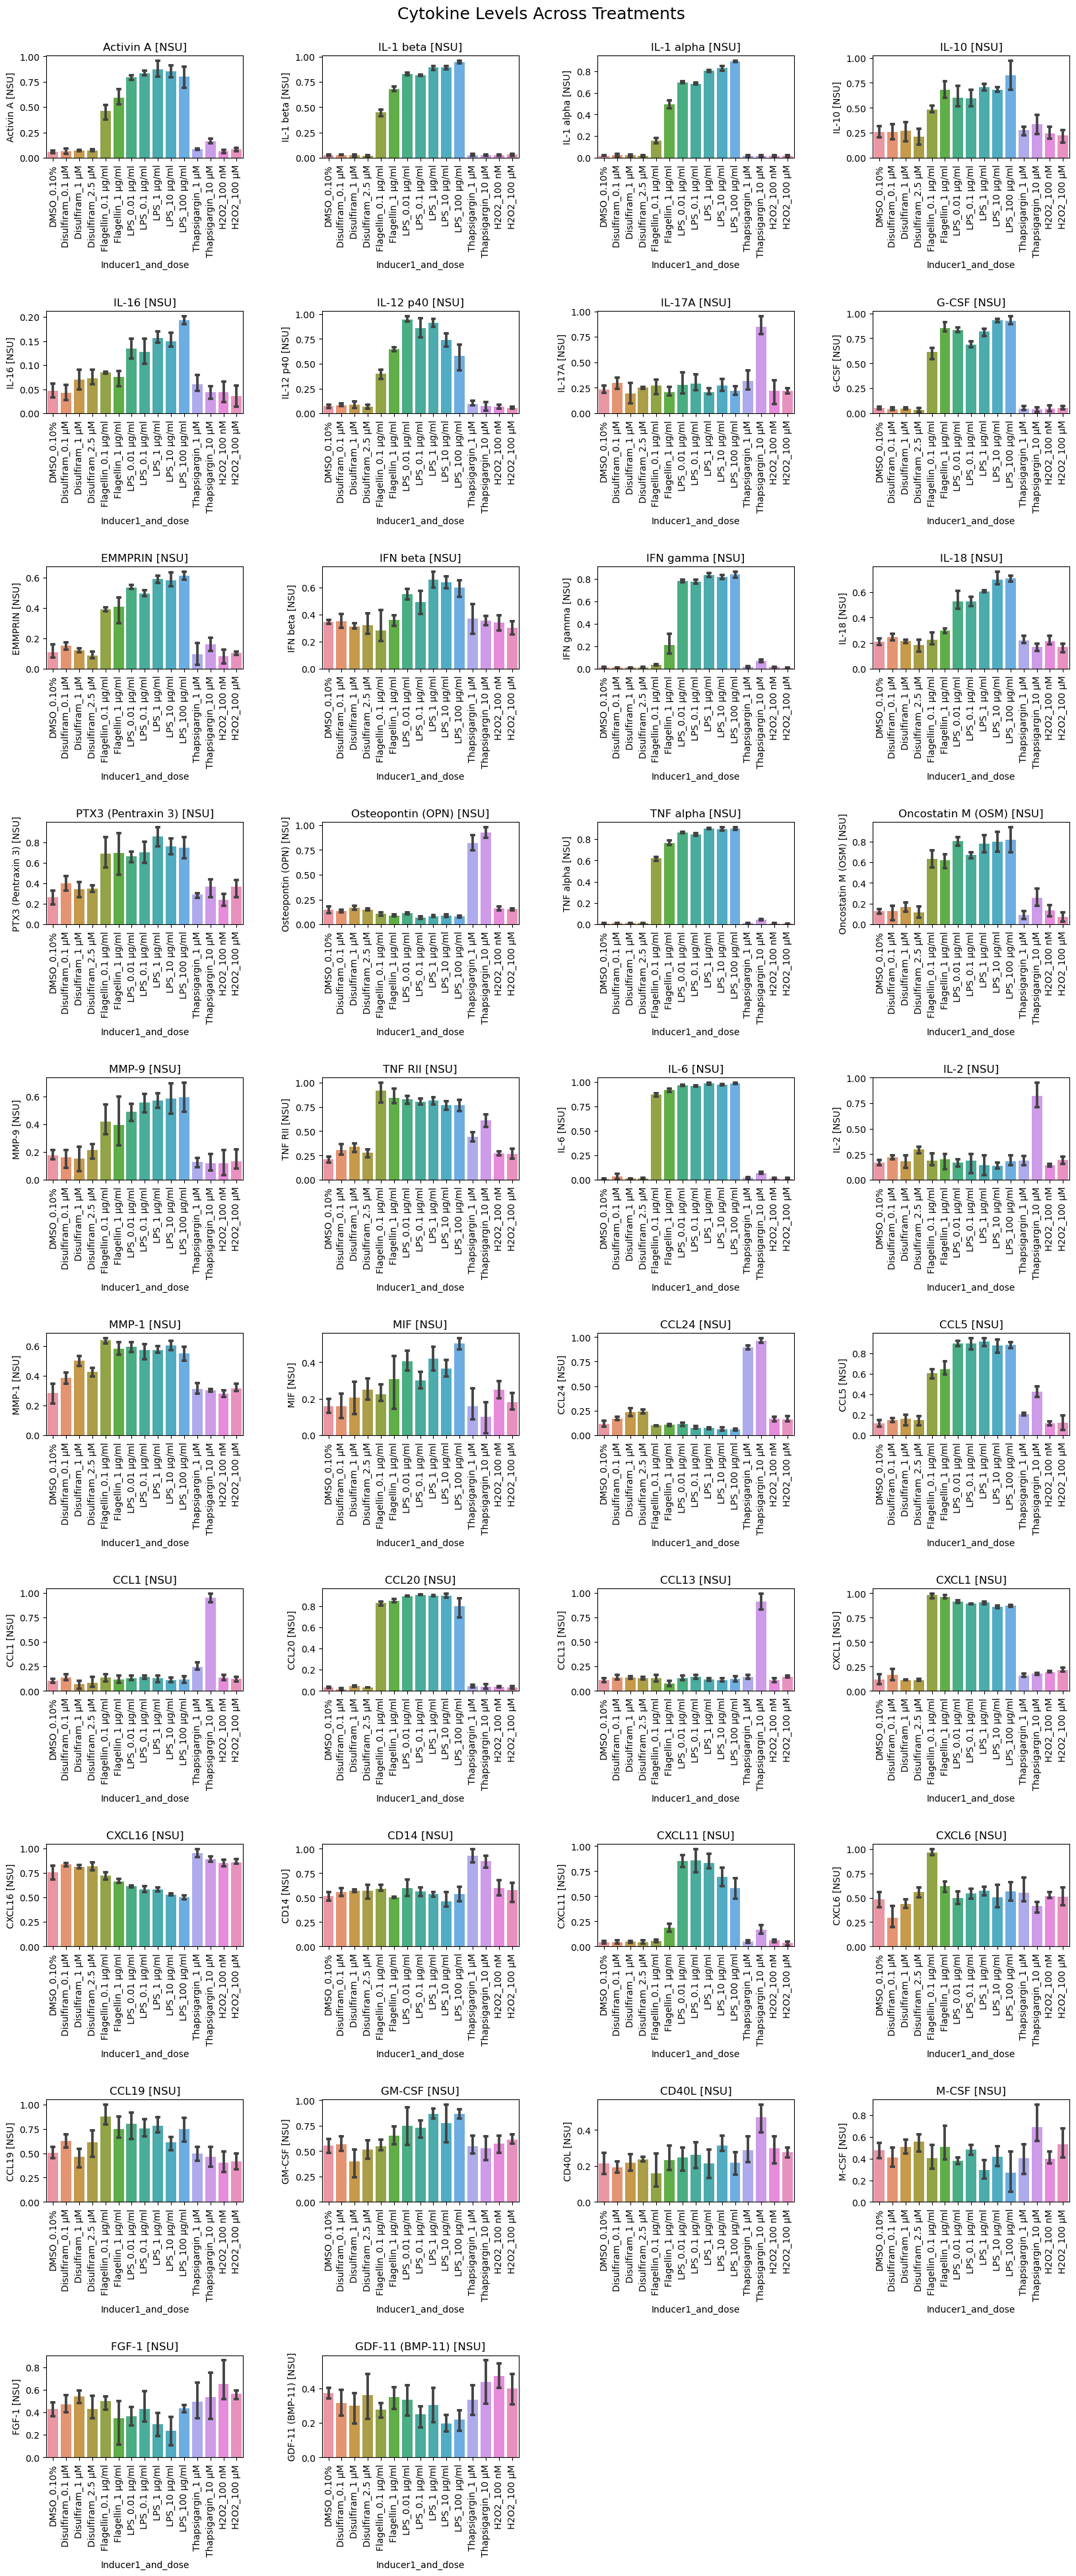

In [10]:
# plot the results of the tukey test for each cytokine
a = len(final_df_tukey["cytokine"].unique())
b = 4
plt.figure(figsize=(20, 150))
plt.suptitle("Cytokine Levels Across Treatments", fontsize=18)
plt.subplots_adjust(top=0.975, bottom=0.01, hspace=1.5, wspace=0.4)
# plt.tight_layout()
# plt.tight_layout()
for col in enumerate(final_df_tukey["cytokine"].unique()):
    # print(col)
    # barplot with confidence intervals for col in final_df_tukey['cytokine'].unique():
    # plt.figure(figsize=(6, 4))
    plt.subplot(a, b, col[0] + 1)
    sns.barplot(
        x="Inducer1_and_dose", y=col[1], data=df, capsize=0.2, order=treatment_order_lst
    )
    # # title
    plt.title(col[1])
    # rotate xticks 90 degrees
    plt.xticks(rotation=90)
    # # save plot
    # # plt.savefig(f'./figures/post_hoc_testing/tukey_test_{col}.png', bbox_inches='tight')
    # # show plot
plt.show()
# # close plot
# # plt.close()

In [11]:
# save the final_df_tukey df to a csv file
final_df_tukey.to_csv("results/tukey_test_results.csv", index=False)

# write the cytokines column to a csv file
cytokines = final_df_tukey["cytokine"].unique()
with open("results/cytokines.csv", "w") as f:
    f.write("cytokine\n")
    for item in cytokines:
        f.write(f"{item}\n")
    f.close()

## Heatmaps of cytokine levels in each treatment

In [12]:
df_cytokines = df[cytokines]
df_cytokines = pd.concat([df["Inducer1_and_dose"], df_cytokines], axis=1)
df_cytokines = df_cytokines.set_index("Inducer1_and_dose")

In [13]:
# filter out treatments that are not of interest
df_cytokines = df_cytokines.drop(
    [
        "Disulfiram_0.1 µM",
        "Disulfiram_1 µM",
        "Disulfiram_2.5 µM",
        "LPS_0.01 µg/ml",
        "LPS_0.1 µg/ml",
    ],
    axis=0,
)

In [14]:
# data_new['Inducer1_and_dose'] = df['Inducer1_and_dose']
# aggregate the data by treatment group via mean
data_agg = df_cytokines.groupby("Inducer1_and_dose").mean()
# heatmap of umap_clusters_with_cytokine_data_agg
# subset the columns to plot
column_list = [col for col in data_agg.columns if "[NSU]" in col]
# subset the rows to plot and label the rows with treatment groups
row_list = data_agg.index
# subset the data to plot
data = data_agg[column_list]

In [15]:
# order the rows by treatment group
treatment_order_lst = [
    "DMSO_0.10%",
    "Thapsigargin_1 µM",
    "Thapsigargin_10 µM",
    "H2O2_100 nM",
    "H2O2_100 µM",
    "Flagellin_0.1 µg/ml",
    "Flagellin_1 µg/ml",
    "LPS_1 µg/ml",
    "LPS_10 µg/ml",
    "LPS_100 µg/ml",
]
data_agg = data_agg.reindex(treatment_order_lst, axis=0)
data_agg

,Activin A [NSU],IL-1 beta [NSU],IL-1 alpha [NSU],IL-10 [NSU],IL-16 [NSU],IL-12 p40 [NSU],IL-17A [NSU],G-CSF [NSU],EMMPRIN [NSU],IFN beta [NSU],...,CXCL16 [NSU],CD14 [NSU],CXCL11 [NSU],CXCL6 [NSU],CCL19 [NSU],GM-CSF [NSU],CD40L [NSU],M-CSF [NSU],FGF-1 [NSU],GDF-11 (BMP-11) [NSU]
Inducer1_and_dose,,,,,,,,,,,,,,,,,,,,,
DMSO_0.10%,0.060957,0.025952,0.019272,0.260939,0.047323,0.071018,0.235254,0.054271,0.110825,0.348613,...,0.753147,0.515770,0.041260,0.482641,0.506946,0.553758,0.212499,0.475837,0.429822,0.370342
Thapsigargin_1 µM,0.084824,0.029131,0.017906,0.278520,0.060271,0.096421,0.318152,0.047726,0.097341,0.369495,...,0.949384,0.928706,0.046884,0.553914,0.496405,0.549588,0.286987,0.405703,0.495488,0.332115
Thapsigargin_10 µM,0.165049,0.026634,0.016866,0.338195,0.043735,0.072414,0.846253,0.036841,0.160048,0.354240,...,0.887312,0.874665,0.169195,0.417898,0.466269,0.527526,0.471905,0.692118,0.537623,0.435751
H2O2_100 nM,0.062708,0.026356,0.019179,0.245874,0.044302,0.067115,0.218658,0.049684,0.081828,0.339520,...,0.846695,0.599040,0.057911,0.519987,0.399653,0.572538,0.300636,0.400659,0.653108,0.472509
H2O2_100 µM,0.082326,0.030836,0.017848,0.222813,0.035996,0.055361,0.220480,0.052696,0.104153,0.302584,...,0.858713,0.577446,0.033925,0.510973,0.417855,0.613133,0.278160,0.535360,0.562601,0.399518
Flagellin_0.1 µg/ml,0.459955,0.448943,0.160742,0.485510,0.084531,0.398772,0.273725,0.615245,0.392399,0.284900,...,0.721175,0.591724,0.056212,0.962653,0.874623,0.546263,0.159161,0.406773,0.498459,0.274644
Flagellin_1 µg/ml,0.592173,0.676829,0.494202,0.677768,0.076010,0.643425,0.209466,0.854067,0.408607,0.360613,...,0.661470,0.501118,0.184268,0.620381,0.745163,0.648618,0.232432,0.508011,0.346492,0.349168
LPS_1 µg/ml,0.871554,0.891465,0.802693,0.706209,0.156638,0.915445,0.209976,0.815832,0.587742,0.658599,...,0.580021,0.535683,0.833110,0.574835,0.781159,0.869015,0.215395,0.294127,0.292849,0.301567
LPS_10 µg/ml,0.850933,0.893372,0.828652,0.678182,0.149784,0.740585,0.269777,0.929666,0.580658,0.640922,...,0.528443,0.463364,0.692570,0.504837,0.611872,0.777809,0.313748,0.416069,0.235072,0.195678


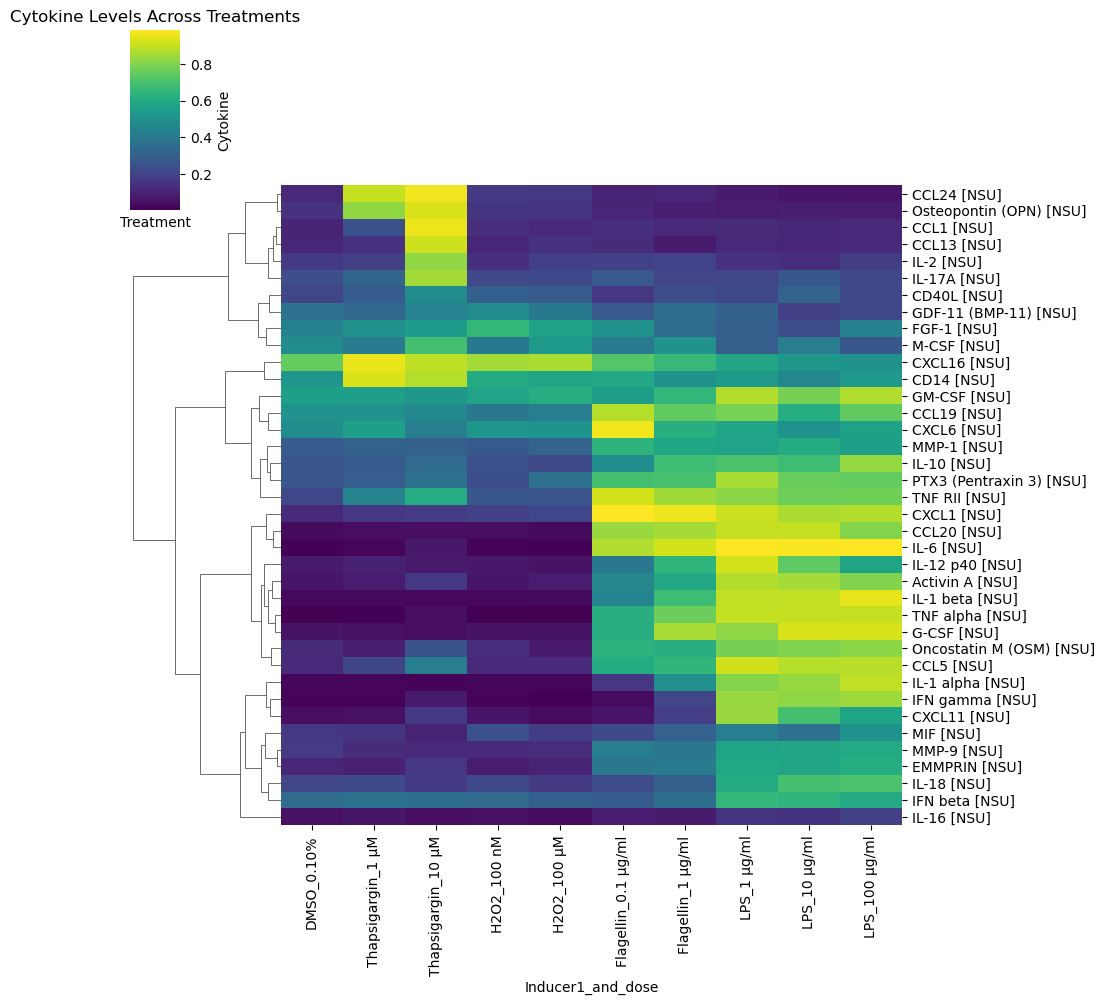

In [16]:
# create the heatmap with dendrogram and cluster the rows and columns with the euclidean distance metric
# order the rows and columns by the linkage matrix generated by the clustering algorithm
# import linkage from scipy.cluster.hierarchy to cluster the rows and columns
from scipy.cluster.hierarchy import linkage

# define the linkage matrix
linkage_df = linkage(
    data_agg.T, metric="euclidean", method="ward", optimal_ordering=True
)

g = sns.clustermap(
    data_agg.T,
    cmap="viridis",
    metric="euclidean",
    method="ward",
    row_cluster=True,
    col_cluster=False,
    row_linkage=linkage_df,
    col_linkage=linkage_df,
)
# rotate the xticks 90 degrees
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.title("Cytokine Levels Across Treatments")
plt.xlabel("Treatment")
plt.ylabel("Cytokine")
# save the heatmap
plt.savefig("./figures/heatmap_PBMC.png", bbox_inches="tight")
# show the heatmap
plt.show()
# close the heatmap